### **The purpose of this assignment is to train, validate, and tune multiple classifiers that can predict, given a set of observations about a person, which income bracket the person fall into.**

In [1]:
# import needed modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import scipy
import time 
import scipy.stats as stats
import operator

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix , make_scorer, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance

### Reading data 

In [2]:
# Reading the train and test data into dataframes
trainDF = pd.read_csv('income-training.csv')
testDF = pd.read_csv('income-testing.csv')

print('Train dataset size is {}\n'.format(trainDF.shape))
print('Test dataset size is {}\n'.format(testDF.shape))
print('Test/Train ratio {}'.format(np.round(len(testDF)/len(trainDF),2)))

Train dataset size is (24421, 15)

Test dataset size is (12211, 15)

Test/Train ratio 0.5


# Exploratory Analysis, Data cleaning & Feature Engineering 

The following sections are very interconnected and thus are done without any specific order

#### Exploratory Analysis
The main goal of this section is to find trends and relations between features and target variable using some visualizing and statistical techniques in order to answer the following question:

**Which of the original attributes in the data are most relevant to an individual's income bracket?**

#### Data Cleaning
The goals of this section are:
1. Handle missing values and justify the approach taken 
2. Answer the question: why the values are missing and how the above taken approach might impact the overal analysis 
3. Convert the categorical data to numerical via encoding method, justify the method used.

#### Feature Engineering 
The main advantages of feature engineering are as follows:
1. It helps to increase the accuracy of predictive model
2. It helps to decrease the chance of overfitting
As a part of Feature engineering, one additional feature is created which is not originally part of the dataset. Moreover, list the importannce of each feature and select the most important features which later, will be used to develop a predictive model (classifier). 

In [3]:
print(trainDF.columns.to_list())
trainDF.head()

['Age', 'WorkClass', 'FinalWeight', 'Education', 'EducationLvl', 'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Sex', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek', 'NativeCountry', 'IncomeBracket']


,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,State-gov,179151,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<50K
1,28,Private,68021,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<50K
2,24,Private,233499,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,50-100K
3,32,Self-emp-not-inc,168782,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32,United-States,<50K
4,55,Self-emp-not-inc,105582,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,2228,0,50,United-States,<50K


In [4]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            24421 non-null  int64 
 1   WorkClass      23037 non-null  object
 2   FinalWeight    24421 non-null  int64 
 3   Education      24421 non-null  object
 4   EducationLvl   24421 non-null  int64 
 5   MaritalStatus  24421 non-null  object
 6   Occupation     23031 non-null  object
 7   Relationship   24421 non-null  object
 8   Race           24421 non-null  object
 9   Sex            24421 non-null  object
 10  CapitalGain    24421 non-null  int64 
 11  CapitalLoss    24421 non-null  int64 
 12  HoursPerWeek   24421 non-null  int64 
 13  NativeCountry  24026 non-null  object
 14  IncomeBracket  24421 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.8+ MB


In [5]:
trainDF.describe()

,Age,FinalWeight,EducationLvl,CapitalGain,CapitalLoss,HoursPerWeek
count,24421.000000,2.442100e+04,24421.000000,24421.000000,24421.00000,24421.000000
mean,38.635273,1.908781e+05,10.100078,1073.734900,90.72581,40.495352
std,13.658678,1.066108e+05,2.579953,7372.250508,410.42682,12.363606
min,17.000000,1.349200e+04,1.000000,0.000000,0.00000,1.000000
25%,28.000000,1.182590e+05,9.000000,0.000000,0.00000,40.000000
50%,37.000000,1.783830e+05,10.000000,0.000000,0.00000,40.000000
75%,48.000000,2.394090e+05,13.000000,0.000000,0.00000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.00000,99.000000


##### Test dataset

In [6]:
testDF.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,57,Self-emp-not-inc,152030,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,25,United-States,50-100K
1,35,Private,341643,Bachelors,13,Never-married,Other-service,Other-relative,White,Male,0,0,50,United-States,<50K
2,26,Private,40915,Bachelors,13,Never-married,Other-service,Not-in-family,White,Female,0,0,25,United-States,<50K
3,27,Federal-gov,257124,Bachelors,13,Never-married,Transport-moving,Other-relative,White,Male,0,0,35,United-States,<50K
4,21,Private,256278,HS-grad,9,Never-married,Other-service,Other-relative,Other,Female,0,0,35,El-Salvador,<50K


In [7]:
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12211 entries, 0 to 12210
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            12211 non-null  int64 
 1   WorkClass      11523 non-null  object
 2   FinalWeight    12211 non-null  int64 
 3   Education      12211 non-null  object
 4   EducationLvl   12211 non-null  int64 
 5   MaritalStatus  12211 non-null  object
 6   Occupation     11521 non-null  object
 7   Relationship   12211 non-null  object
 8   Race           12211 non-null  object
 9   Sex            12211 non-null  object
 10  CapitalGain    12211 non-null  int64 
 11  CapitalLoss    12211 non-null  int64 
 12  HoursPerWeek   12211 non-null  int64 
 13  NativeCountry  11986 non-null  object
 14  IncomeBracket  12211 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.4+ MB


In [8]:
testDF.describe()

,Age,FinalWeight,EducationLvl,CapitalGain,CapitalLoss,HoursPerWeek
count,12211.000000,1.221100e+04,12211.000000,12211.000000,12211.000000,12211.000000
mean,38.856031,1.873615e+05,10.110228,1203.788961,88.256162,40.497994
std,13.705457,1.046019e+05,2.533795,8057.146114,404.810323,12.283195
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.162960e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.769000e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.345370e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


According to the above analysis:

- There are 14 features: 8 out of 14 are categorical data and 6 out of 14 are continuous cvariables.
- There are missing data in both train and test dataset's columns : WorkClass, Occupation, NativeCountry (all categorical data)
- Numerical data are in different ranges and needed to be normalized/scaled. Note that in order to prevent data leakage the scaler shoud be fitted on;y on train dataset.

In [9]:
# Remove duplicates
trainDF.drop_duplicates(keep = 'first', inplace = True)
testDF.drop_duplicates(keep = 'first', inplace = True)

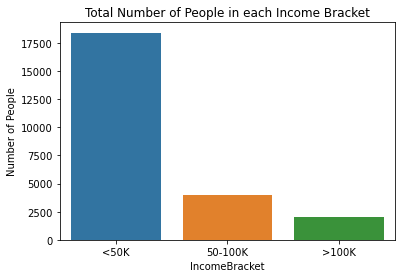

In [10]:
# Target Variable
sns.countplot(x='IncomeBracket',data=trainDF)
plt.ylabel('Number of People')
plt.title('Total Number of People in each Income Bracket')
plt.show()

The above plot shows that most people in our dataset fall in the <50K income bracket. Also, as the income level goes up, the number of people/observations decrease.  
This shows that the class with >100K is a very small class with much less examples and training data when implementing classifiers, thus, it is anticipated for this class to have the highest error. The middle class will also have higher error than the <50K class.

#### Gender vs Income Bracket

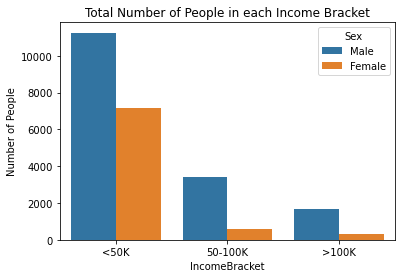

In [11]:
sns.countplot(x='IncomeBracket', hue='Sex', data=trainDF)
plt.ylabel('Number of People')
plt.title('Total Number of People in each Income Bracket')
plt.show()

In [12]:
# total number of males and females in each of the categories 
income_gender_bracket = trainDF.groupby(['IncomeBracket','Sex']).size()
print (trainDF['Sex'].describe())
print(income_gender_bracket)

count     24410
unique        2
top        Male
freq      16352
Name: Sex, dtype: object
IncomeBracket  Sex   
50-100K        Female      581
               Male       3413
<50K           Female     7172
               Male      11250
>100K          Female      305
               Male       1689
dtype: int64


Here we see that total number of females in the dataset is actually much less than half of data on males.

Moreover, we can see that ratio of females in the <50k bracket is higher than the other two when compared to males. 

**Less data on females may lead to higher error in classifying females in higher income brackets than males.** 

#### Gender vs HoursPerWeek

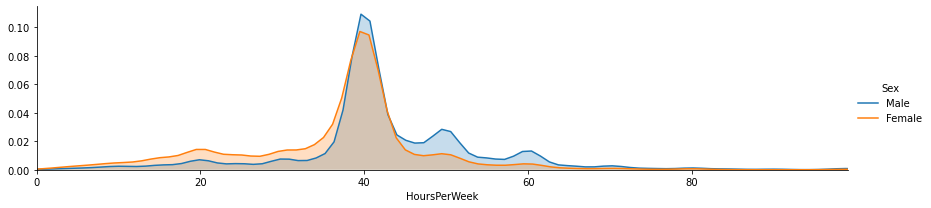

In [13]:
facet = sns.FacetGrid(trainDF, hue="Sex",aspect=4)
facet.map(sns.kdeplot,'HoursPerWeek',shade= True)
facet.set(xlim=(0, trainDF['HoursPerWeek'].max()))
facet.add_legend()
plt.show()

In the above graph we see than the peak of hours of work per week for both males and females is 40 hrs/week, which is the standard. However, there are more males compared to females that work for longer hours in a week and more females than males that work less than 40 hours per week. Since the total number of male observations are highr than that for females, More investigation is neaded to verify the correctness of statements. 
Below we will see whether there is any difference between the average number of hours of work per week between the two genders among different occupation categories. 

C:\Users\falak\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\falak\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


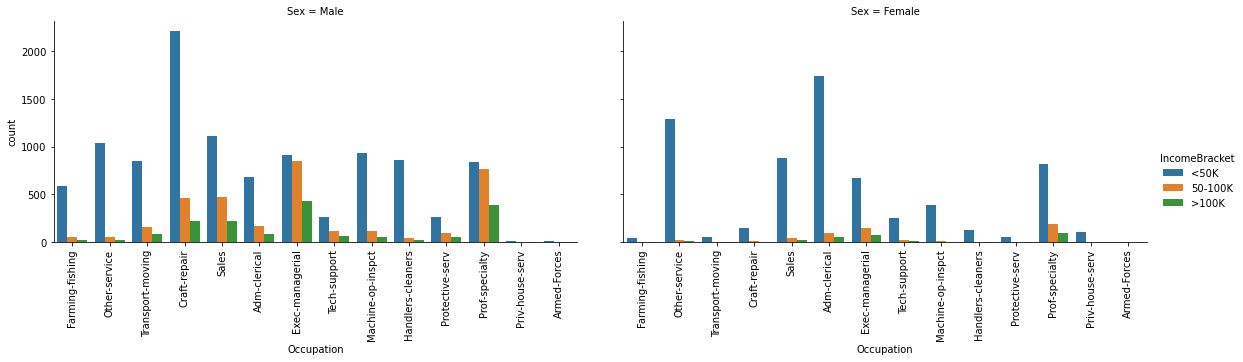

In [14]:
g = sns.factorplot(x="Occupation", hue='IncomeBracket', col="Sex",
                   data=trainDF, kind="count", size=4, aspect=2, estimator=np.mean)
g.set_xticklabels(rotation=90)
plt.show()

Factorplot with mean estimator takes into account that there are less data on females. The major differences between two genders are in specific occupation categories of Farming/fishing, Transportation, and Craft/Repairs, where males seem to be dominating. I expect these classes to be more important than the rest. Furhtermore, there is better distribution of data in the male category of Exec and Prof and these two would more likely play a role in determining income brackets. 

#### Age vs Income Bracket

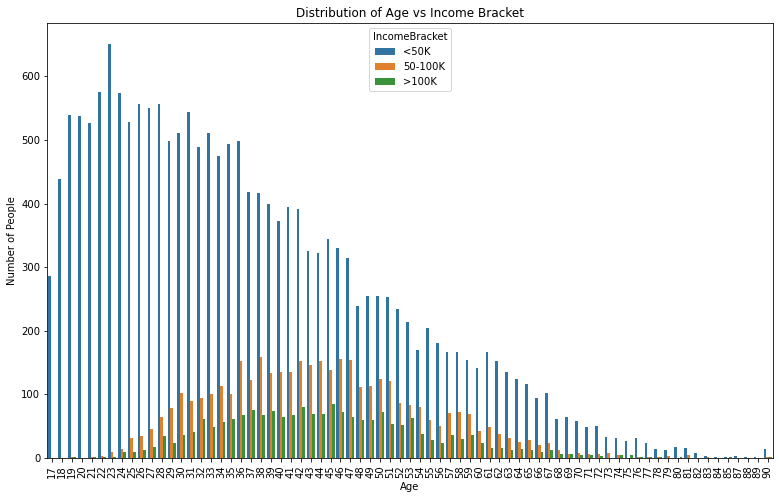

In [15]:
ax, figure = plt.subplots(figsize=(13,8))
sns.countplot(x='Age',hue='IncomeBracket',  data=trainDF)
plt.xticks( rotation = 90)
plt.ylabel('Number of People')
plt.title('Distribution of Age vs Income Bracket')
plt.show()

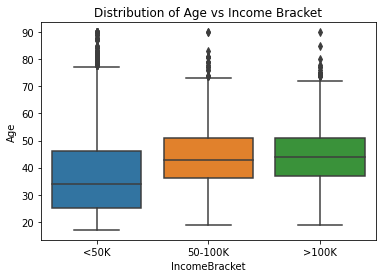

In [16]:
sns.boxplot(x='IncomeBracket', y='Age', data=trainDF)
plt.title('Distribution of Age vs Income Bracket')
plt.show()

From the above plots we see that the people in the lowest income bracket are much younger, and people in the highest income bracket are only slightly older than the middle braket on average. There is a clear differences between the classes and I expect this feature to play an important role in classification.

#### Capital Gain vs Income Bracket

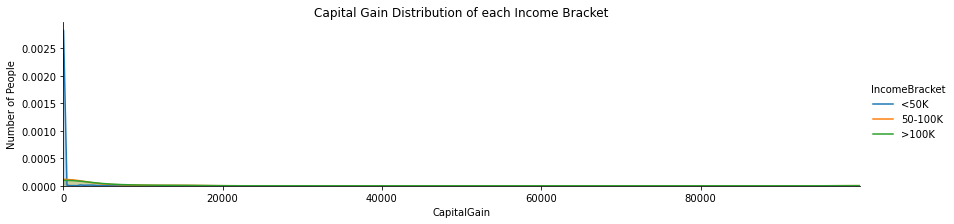

In [17]:
facet = sns.FacetGrid(trainDF, hue="IncomeBracket",aspect=4)
facet.map(sns.kdeplot,'CapitalGain',shade= True)
facet.set(xlim=(0, trainDF['CapitalGain'].max()))
facet.add_legend()
plt.ylabel('Number of People')
plt.title('Capital Gain Distribution of each Income Bracket')
plt.show()

This plot shows the gain of income by selling assets. In this graph, we see clear differences among classes, and thus can say that this feature is going to be important in determining various classes. (Positive correlation)

<50K class has less than 15k in capital gain 

while 50-100K has less than 35k in capital gain 

and 100< has the most capital gain 

#### Education Trends

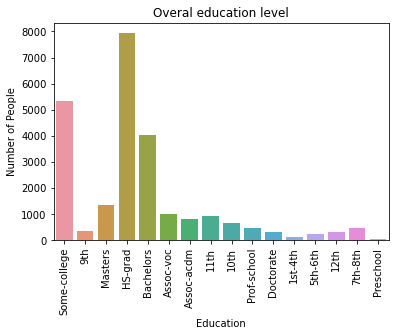

In [18]:
sns.countplot(x='Education',  data=trainDF)
plt.xticks( rotation = 90)
plt.ylabel('Number of People')
plt.title('Overal education level')
plt.show()

Here we see that the majority of people fall into high school grad, followed by some collage education, and then having bachelor degree. 

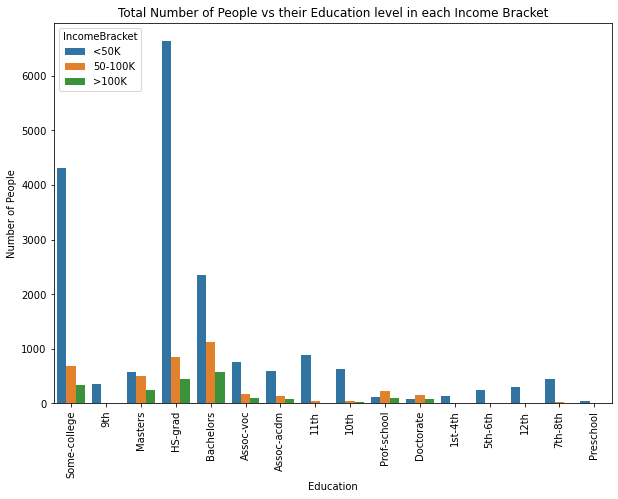

In [19]:
ax, figure = plt.subplots(figsize=(10,7))
sns.countplot(x='Education', hue='IncomeBracket', data=trainDF)
plt.ylabel('Number of People')
plt.xticks( rotation = 90)
plt.title('Total Number of People vs their Education level in each Income Bracket')
plt.show()

Here shows that at the extreme of the education levels, doctorate vs elementary school level, majority will either be in >100k level (doctorate), or <50k (elementary level education). This feature is important for the highest and lowest education level for determining the correct category. 

## Handling missing data

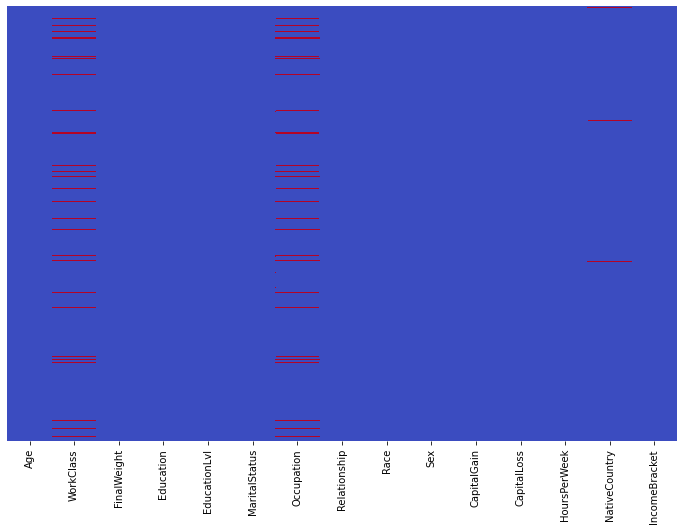

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(trainDF.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
plt.show()

The above graph visualizes that there are three columns with missing data in them, namely, WorkClass, Occupation, and NativeCountry. Furhtermore, the heat map shows that the data entries with missing Occupation and WorkClass are very similar. In fact, below we see that there are only 6 entries that have Work class, but not the occupation, and the rest of the data miss both enteries.    
Similarly the missing data for the test data is visualized and can be shown that same features are missing data.

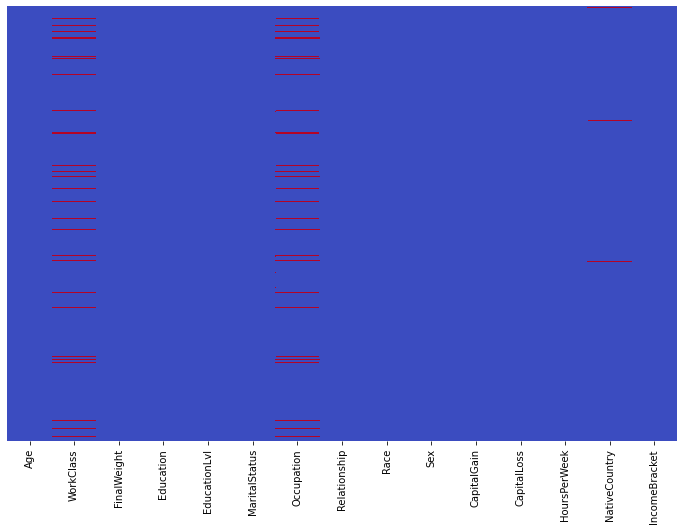

In [21]:
# here we see that the test data also is missing values for the same features 
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(trainDF.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
plt.show()

Some of the reasons these features are missing data might be because the Ocuupation/Work Class wasn't in the list and people just didn't fill in these categories when filling surveys. Some people might be from States and just didnt fill the native country or maybe their native country wasn't an option to choose from. 

Let's look at the rows of the data with missing information.

In [22]:
print("Data enteries total count for missing Occupation entry")
print(trainDF.loc[trainDF.Occupation.isnull()].count())
print("Data enteries total count for missing WorkClass entry")
print(trainDF.loc[trainDF.WorkClass.isnull()].count())

Data enteries total count for missing Occupation entry
Age              1389
WorkClass           6
FinalWeight      1389
Education        1389
EducationLvl     1389
MaritalStatus    1389
Occupation          0
Relationship     1389
Race             1389
Sex              1389
CapitalGain      1389
CapitalLoss      1389
HoursPerWeek     1389
NativeCountry    1371
IncomeBracket    1389
dtype: int64
Data enteries total count for missing WorkClass entry
Age              1383
WorkClass           0
FinalWeight      1383
Education        1383
EducationLvl     1383
MaritalStatus    1383
Occupation          0
Relationship     1383
Race             1383
Sex              1383
CapitalGain      1383
CapitalLoss      1383
HoursPerWeek     1383
NativeCountry    1365
IncomeBracket    1383
dtype: int64


In [23]:
trainDF.loc[(trainDF.Occupation.isnull()) & (trainDF.WorkClass.notnull())]

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
967,18,Never-worked,153663,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,4,United-States,<50K
5364,18,Never-worked,206359,10th,6,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<50K
12944,23,Never-worked,188535,7th-8th,4,Divorced,NaN,Not-in-family,White,Male,0,0,35,United-States,<50K
13116,17,Never-worked,131593,11th,7,Never-married,NaN,Own-child,Black,Female,0,0,20,United-States,<50K
21769,20,Never-worked,462294,Some-college,10,Never-married,NaN,Own-child,Black,Male,0,0,40,United-States,<50K
22910,17,Never-worked,237272,10th,6,Never-married,NaN,Own-child,White,Male,0,0,30,United-States,<50K


In [24]:
testDF.loc[(testDF.Occupation.isnull()) & (testDF.WorkClass.notnull())]

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
6035,20,Never-worked,273905,HS-grad,9,Married-spouse-absent,NaN,Other-relative,White,Male,0,0,35,United-States,<50K
11455,18,Never-worked,162908,11th,7,Never-married,NaN,Own-child,White,Male,0,0,35,United-States,<50K


From the rows that miss the occupation, but have the work class, we see that the reason these individuals are missing the occupation is the fact that they don't have any oocupation to enter. In fact, the occupation has no category of unemployed. Since these individuals never worked, we will add a category to the occupation and call it unemployed

In [25]:
trainDF.loc[(trainDF.Occupation.isnull()) & (trainDF.WorkClass.notnull()), 'Occupation'] = 'Unemployed'
testDF.loc[(testDF.Occupation.isnull()) & (testDF.WorkClass.notnull()), 'Occupation'] = 'Unemployed'

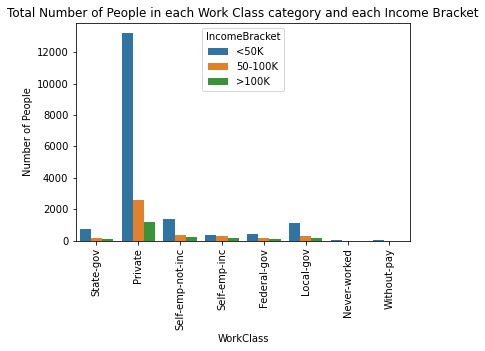

In [26]:
# explore the Workclass of dataset 
sns.countplot(x='WorkClass', hue='IncomeBracket', data=trainDF)
plt.ylabel('Number of People')
plt.xticks( rotation = 90)
plt.title('Total Number of People in each Work Class category and each Income Bracket')
plt.show()

In the above plot we see that the majority of data fall into the private category, thus, for the missing data the probability that they fall into private category is the highest and therefore I picked this category for the rest of missing data.  

In [27]:
trainDF.loc[trainDF.WorkClass.isnull(), 'WorkClass'] = 'Private'
testDF.loc[testDF.WorkClass.isnull(), 'WorkClass'] = 'Private'
# verify 
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24410 entries, 0 to 24420
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            24410 non-null  int64 
 1   WorkClass      24410 non-null  object
 2   FinalWeight    24410 non-null  int64 
 3   Education      24410 non-null  object
 4   EducationLvl   24410 non-null  int64 
 5   MaritalStatus  24410 non-null  object
 6   Occupation     23027 non-null  object
 7   Relationship   24410 non-null  object
 8   Race           24410 non-null  object
 9   Sex            24410 non-null  object
 10  CapitalGain    24410 non-null  int64 
 11  CapitalLoss    24410 non-null  int64 
 12  HoursPerWeek   24410 non-null  int64 
 13  NativeCountry  24015 non-null  object
 14  IncomeBracket  24410 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.6+ MB


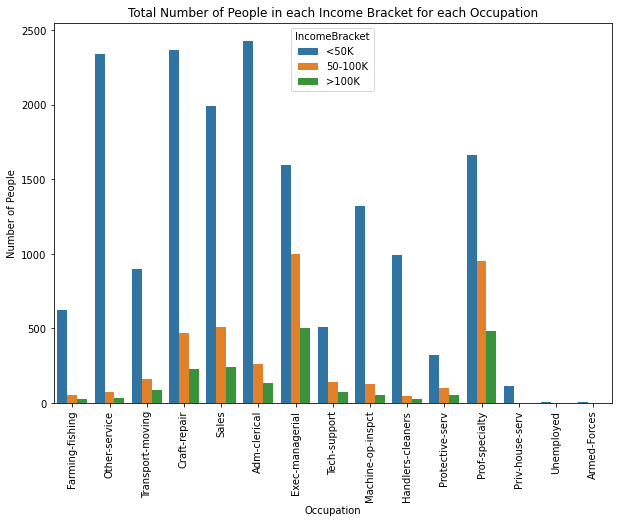

In [28]:
# lets see distribution of occupation
ax, figure = plt.subplots(figsize=(10,7))
sns.countplot(x='Occupation',hue='IncomeBracket',data=trainDF)
plt.ylabel('Number of People')
plt.title('Total Number of People in each Income Bracket for each Occupation')
plt.xticks( rotation = 90)
plt.show()

Here we see that almost all occupations have all three income level except for Private house services and armed forces. All occupation categories have more peole within <50k income bracket than other two levels. The executive management and specialty professor categories have the highest number of people that fall within the two higher income brackets. Furthermore, the top three categories with the most number of people in them are Admin services, craft repair, and other services. 
Next we see whether there is any difference between gender and income bracket, rational being
that as the occupation category becomes more specialty, the education level is higher. 

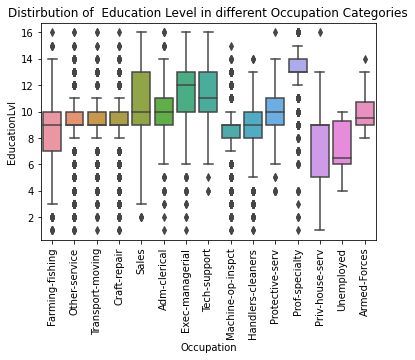

In [29]:
# lets explore the relationship between occupation and the education level
plt.title('Distirbution of  Education Level in different Occupation Categories')
plt.xticks(rotation=90)
sns.boxplot(x="Occupation", y="EducationLvl", data=trainDF)
plt.show()

C:\Users\falak\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


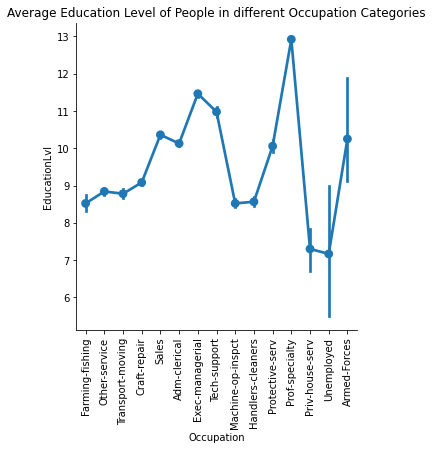

In [31]:
sns.factorplot(x="Occupation", y='EducationLvl', data=trainDF, estimator=np.mean)
plt.title('Average Education Level of People in different Occupation Categories')
plt.xticks(rotation=90)
plt.show()

From the above plots, we see that education level matters for some occupation categories. For example prof-specialty has the highest value for its mean in the education level, therefore, some of the missing data can be categories based on their education level as followed. As the number of managers is more than the tech support we place all the missing data in education level 12 and 11 into managerial position although both occupations have close means with mean education level of tech support being close to 11 as well. Since sales has alot of observations with mean education level 10, we replace the missing data with education level 10 to sales, replace missing of 9 to clerks, <7 to priv-services, and drop the rest. 
The goal here was to keep as many observations as possible, in order to have more data to train the models with. Although these classes might not be as significant of other classes in education level in determining income bracket, assigning numbers to them allows us to preserve the information. The implication of replacing one variable based on another one however, is that this may result in increasing the corrolation that exist between occupation and education level variables. 

In [32]:
trainDF.loc[(trainDF.EducationLvl >= 13)&(trainDF.Occupation.isnull()) , 'Occupation'] = 'Prof-specialty'
trainDF.loc[(trainDF.EducationLvl == 12)&(trainDF.Occupation.isnull()) , 'Occupation'] = 'Exec-managerial'
trainDF.loc[(trainDF.EducationLvl == 11)&(trainDF.Occupation.isnull()) , 'Occupation'] = 'Exec-managerial'
trainDF.loc[(trainDF.EducationLvl == 10)&(trainDF.Occupation.isnull()) , 'Occupation'] = 'Sales'
trainDF.loc[(trainDF.EducationLvl == 9)&(trainDF.Occupation.isnull()) , 'Occupation'] = 'Adm-clerical'
trainDF.loc[(trainDF.EducationLvl < 7)&(trainDF.Occupation.isnull()) , 'Occupation'] = 'Priv-house-serv'

testDF.loc[(testDF.EducationLvl >= 13)&(testDF.Occupation.isnull()) , 'Occupation'] = 'Prof-specialty'
testDF.loc[(testDF.EducationLvl == 12)&(testDF.Occupation.isnull()) , 'Occupation'] = 'Exec-managerial'
testDF.loc[(testDF.EducationLvl == 11)&(testDF.Occupation.isnull()) , 'Occupation'] = 'Exec-managerial'
testDF.loc[(testDF.EducationLvl == 10)&(testDF.Occupation.isnull()) , 'Occupation'] = 'Sales'
testDF.loc[(testDF.EducationLvl == 9)&(testDF.Occupation.isnull()) , 'Occupation'] = 'Adm-clerical'
testDF.loc[(testDF.EducationLvl < 7)&(testDF.Occupation.isnull()) , 'Occupation'] = 'Priv-house-serv'
#other occupation categories have close to one another means, are small subset and we can't
# guess with any good accuracy thus we drop the data 
#set the missing values of the Occupation column 
trainDF.dropna(subset=['Occupation'],inplace = True) 
testDF.dropna(subset=['Occupation'],inplace = True) 
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24303 entries, 0 to 24420
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            24303 non-null  int64 
 1   WorkClass      24303 non-null  object
 2   FinalWeight    24303 non-null  int64 
 3   Education      24303 non-null  object
 4   EducationLvl   24303 non-null  int64 
 5   MaritalStatus  24303 non-null  object
 6   Occupation     24303 non-null  object
 7   Relationship   24303 non-null  object
 8   Race           24303 non-null  object
 9   Sex            24303 non-null  object
 10  CapitalGain    24303 non-null  int64 
 11  CapitalLoss    24303 non-null  int64 
 12  HoursPerWeek   24303 non-null  int64 
 13  NativeCountry  23908 non-null  object
 14  IncomeBracket  24303 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.0+ MB


the top category is United-States, with total entries of 95.5%


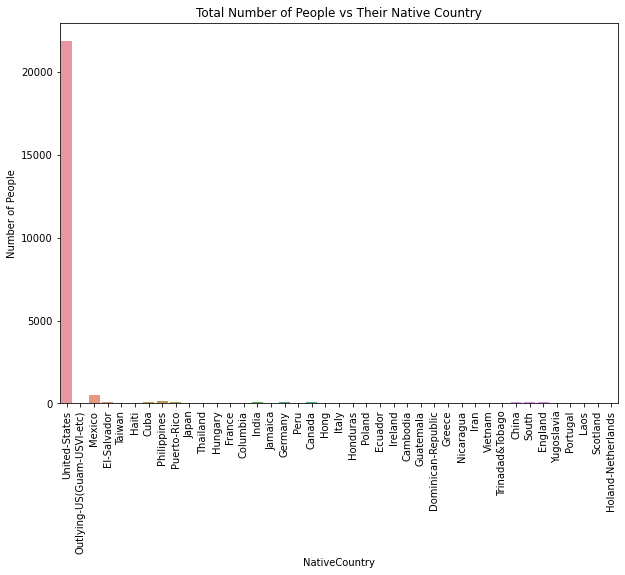

In [33]:
# Lets see what is the distribution of the native country in the dataset 
native= trainDF['NativeCountry'].describe()
print('the top category is {}, with total entries of {}%'.format(native.top, round((native.freq/22898)*100,1)))
ax, figure = plt.subplots(figsize=(10,7))
sns.countplot(x='NativeCountry', data=trainDF)
plt.ylabel('Number of People')
plt.xticks( rotation = 90)
plt.title('Total Number of People vs Their Native Country')
plt.show()

In the above plot we see that more than 90% of entries have USA as their Native country. Thus, we convert the missing data to defult of US.

In [34]:
# Set the defult NativeCountry of the missing data to United-States 
trainDF.loc[trainDF.NativeCountry.isnull() , 'NativeCountry'] = 'United-States'
testDF.loc[testDF.NativeCountry.isnull() , 'NativeCountry'] = 'United-States'

Let's see if there is any difference between the information provided between the Education and EducationLvl columns. 

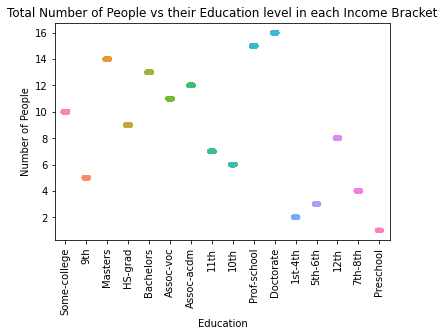

In [35]:
sns.stripplot(x="Education", y="EducationLvl", data=trainDF, jitter=True)
plt.ylabel('Number of People')
plt.xticks( rotation = 90)
plt.title('Total Number of People vs their Education level in each Income Bracket')
plt.show()

From the above plot we see that the information provided in two columns are redundat, in fact the EducationLvl is just numerical values of the Education level of the individual. Since the algorithms only work with numerical values and not string entries, we can drop Education column and keep EducationLvl only with no loss of data. 

In [36]:
trainDF = trainDF.drop(['Education'], axis=1)
testDF = testDF.drop(['Education'], axis=1)

### Converting the categorical data to numerical

Categorical variables needs to be converted into numerical values since scikit-learn only takes numerical values as input in a numpy array. We can do this by encoding the categorical values with dummy variables. This method uses one-hot-coding such that each category for each feature becomes a new column. A category's column will get a value of 1 if the original feature belonged to that category. Only one of the categorical feature columns can have of 1. One-hot-coding is much better than just giving numerical values as it prevents ordinal interpretation by the algorithms used. The draw back is the number of columns increases and the data is stored as large sparse martix.  

In [37]:
dummies_WorkClass_train = pd.get_dummies(trainDF['WorkClass'], prefix='WorkClass')
dummies_MaritalStatus_train = pd.get_dummies(trainDF['MaritalStatus'], prefix='MaritalStatus')
dummies_Occupation_train = pd.get_dummies(trainDF['Occupation'], prefix='Occupation')
dummies_Relationship_train = pd.get_dummies(trainDF['Relationship'], prefix='Relationship')
dummies_Race_train = pd.get_dummies(trainDF['Race'], prefix='Race')
dummies_Sex_train = pd.get_dummies(trainDF['Sex'], prefix='Sex')
dummies_NativeCountry_train = pd.get_dummies(trainDF['NativeCountry'], prefix='NativeCountry')

# Add the new features to the dataframe via concating
tempDF = pd.concat([trainDF, dummies_WorkClass_train, dummies_MaritalStatus_train,
                    dummies_Occupation_train, dummies_Relationship_train,
                   dummies_Race_train, dummies_Sex_train, dummies_NativeCountry_train], axis=1)

# Drop the original categorical feature columns
tempDF = tempDF.drop(['WorkClass','MaritalStatus','Occupation','Relationship',
                     'Race', 'Sex', 'NativeCountry'],axis=1)

# Drop one of each of the dummy variables because its value is implied
X_train = tempDF.drop(['WorkClass_Never-worked','MaritalStatus_Never-married',
                       'Occupation_Unemployed','Relationship_Other-relative',
                        'Race_Other', 'Sex_Male', 'NativeCountry_Cuba'],axis=1)

X_train.head()

,Age,FinalWeight,EducationLvl,CapitalGain,CapitalLoss,HoursPerWeek,IncomeBracket,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_Private,...,NativeCountry_Portugal,NativeCountry_Puerto-Rico,NativeCountry_Scotland,NativeCountry_South,NativeCountry_Taiwan,NativeCountry_Thailand,NativeCountry_Trinadad&Tobago,NativeCountry_United-States,NativeCountry_Vietnam,NativeCountry_Yugoslavia
0,42,179151,10,0,0,40,<50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,28,68021,10,0,0,30,<50K,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,24,233499,10,0,0,40,50-100K,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,32,168782,5,0,0,32,<50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,55,105582,14,2228,0,50,<50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Baseline performance

Run one of the algorithms (Logistic Regression here) on all of the data without any feature engineering to ensure that the added features are actually working in improving the results. I chose logistic regression, a common classifier algorithm, for baseline performance 

##### Rescalling values 
Having features that have different scales can cause problems in some machine learning models since a lot of the models are based on the concept of Euclidean Distances. This means that features with greater scales would have a greater impact on the solution than those of smaller values. We can rectify this situation by scaling the independent values. This can be done with the scaler function.

In [38]:
scaler = StandardScaler()
X_all = X_train.drop(['IncomeBracket'], axis=1)
X_all = scaler.fit_transform(X_all)

dic = {'<50K': 0, '50-100K':1, '>100K':2}
trainDF['IncomeBracket'] = trainDF['IncomeBracket'].map(dic)
testDF['IncomeBracket'] = testDF['IncomeBracket'].map(dic)
y = trainDF.IncomeBracket

##### Evaluation: Cross Validation

When building a model, we want one that can generalize (low bias), and have similar accuracies across testing sets (low variance). Cross-validation partitions the training set into various training and testing sets and we use these sets to train and test the model multiple times. KFold Cross Validation is a common method where the training set is split into k equal sizes. Then of the k subsamples, a single sample is used for testing, and the remaining k-1 samples are used for training. This process continues k times, and each time a different sample is used for testing. This results in each sample being tested once. At the end of this we get 10 accuracies for the model and, from this, we can get the average accuracy, and the standard deviation of the accuracy. The higher the average accuracy, the lower the bias. The lower the standard deviation, the lower the variance, thus, representing the true performance of the model on the training set.

In [39]:
def kfold_model_run(model, X, y, K=10):
    kfold = KFold(n_splits=K)
    kfold.get_n_splits(X)
    accuracy = np.zeros(K)
    np_idx = 0
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        ACC = accuracy_score(y_test, predictions)
        accuracy[np_idx] = ACC*100
        np_idx += 1

        print ("Fold {}: Accuracy: {}".format(np_idx, round(ACC,3)))   
    
    print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))
    return model

In [40]:
# run the logistic regression model with all  the features included
start_time = time.time()
lg = LogisticRegression()
kfold_model_run(lg, X_all, y)
elapsedtime = time.time() - start_time
print('Time taken to run this model is {}'.format(elapsedtime))
print('Total number of features are: {}'.format(X_all.shape[1]))

C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 1: Accuracy: 0.802
Fold 2: Accuracy: 0.801


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 3: Accuracy: 0.799


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 4: Accuracy: 0.815


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 5: Accuracy: 0.809


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 6: Accuracy: 0.802


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 7: Accuracy: 0.798


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 8: Accuracy: 0.797


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 9: Accuracy: 0.806
Fold 10: Accuracy: 0.793
Average Score: 80.221%(0.618%)
Time taken to run this model is 19.86723494529724
Total number of features are: 83


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The above about 80% is our baseline accuracy. 
When a feature has a lot of categories, a lot of new columns are generated. Not all columns however are significant, thus we can eliminate some of the columns. For example, more than 90% have USA as their native country, and the very small amount of data are scattered into large category of other countries. We eliminate many columns by only keeping the dummy variable that provides yes or no for USA as native country and eleminate the rest for the Native Country feature. 

### Feature Selection

In [41]:
trainDF.loc[trainDF['NativeCountry'] != 'United-States', 'NativeCountry'] = 'Other'
testDF.loc[testDF['NativeCountry'] != 'United-States', 'NativeCountry'] = 'Other'

By looking at the feature definitions, we see a lot of common information in Relationship and MaritalStatus. Since both are categorical variables, we perform chi-square test on them to see if the variables have any dependance in one another. 

In [42]:
relations = pd.crosstab(trainDF['Relationship'],trainDF['MaritalStatus'])
chi, p, dof, expected = stats.chi2_contingency(relations)
print('p-value is {}, and Chi-squared value is {}'.format(p,chi))

p-value is 0.0, and Chi-squared value is 28833.71605564572


from above we conclude that the association between the two features is strong. In order to reduce columns we convert the categories in MaritalStatus in either single, married, or married-spouse-absent. Since these two valiables share similar info and are dependant, we can select one for modeling and eliminate the other. This I did after I obtain my most important features from the gradient boost search of most important features. 

In [43]:
trainDF['MaritalStatus'].replace(['Married-civ-spouse', 'Married-AF-spouse'], 'Married',inplace= True)
trainDF['MaritalStatus'].replace(['Divorced', 'Never-married','Separated','Widowed'], 'Single',inplace= True)

testDF['MaritalStatus'].replace(['Married-civ-spouse', 'Married-AF-spouse'], 'Married',inplace= True)
testDF['MaritalStatus'].replace(['Divorced', 'Never-married','Separated','Widowed'], 'Single',inplace= True)
trainDF.groupby(['Relationship',"MaritalStatus"]).count()

Age  WorkClass  FinalWeight  \
Relationship   MaritalStatus                                         
Husband        Married                9904       9904         9904   
Not-in-family  Married                  10         10           10   
               Married-spouse-absent   145        145          145   
               Single                 6100       6100         6100   
Other-relative Married                 101        101          101   
               Married-spouse-absent    27         27           27   
               Single                  601        601          601   
Own-child      Married                  81         81           81   
               Married-spouse-absent    32         32           32   
               Single                 3586       3586         3586   
Unmarried      Married-spouse-absent    99         99           99   
               Single                 2438       2438         2438   
Wife           Married                1179       1179         1179   

                                      EducationLvl  Occupation  Race   Sex  \
Relationship   MaritalStatus                                                 
Husband        Married                        9904        9904  9904  9904   
Not-in-family  Married                          10          10    10    10   
               Married-spouse-absent           145         145   145   145   
               Single                         6100        6100  6100  6100   
Other-relative Married                         101         101   101   101   
               Married-spouse-absent            27          27    27    27   
               Single                          601         601   601   601   
Own-child      Married                          81          81    81    81   
               Married-spouse-absent            32          32    32    32   
               Single                         3586        3586  3586  3586   
Unmarried      Married-spouse-absent            99          99    99    99   
               Single                         2438        2438  2438  2438   
Wife           Married                        1179        1179  1179  1179   

                                      CapitalGain  CapitalLoss  HoursPerWeek  \
Relationship   MaritalStatus                                                   
Husband        Married                       9904         9904          9904   
Not-in-family  Married                         10           10            10   
               Married-spouse-absent          145          145           145   
               Single                        6100         6100          6100   
Other-relative Married                        101          101           101   
               Married-spouse-absent           27           27            27   
               Single                         601          601           601   
Own-child      Married                         81           81            81   
               Married-spouse-absent           32           32            32   
               Single                        3586         3586          3586   
Unmarried      Married-spouse-absent           99           99            99   
               Single                        2438         2438          2438   
Wife           Married                       1179         1179          1179   

                                      NativeCountry  IncomeBracket  
Relationship   MaritalStatus                                        
Husband        Married                         9904           9904  
Not-in-family  Married                           10             10  
               Married-spouse-absent            145            145  
               Single                          6100           6100  
Other-relative Married                          101            101  
               Married-spouse-absent             27             27  
               Single                           601            6

From above we see that relationship feature provides similar information, but not quite the same. Since Husband and wife are guarantteed to be married, moving forward we convert husbad and wife into married, to eliminate a redundant column, as married with sex info would provide us with full info as wife/husband would. 

In [44]:
trainDF['Relationship'].replace(['Husband', 'Wife'], 'Married',inplace= True)
testDF['Relationship'].replace(['Husband', 'Wife'], 'Married',inplace= True)

In [45]:
corr = trainDF.corr()
corr

,Age,FinalWeight,EducationLvl,CapitalGain,CapitalLoss,HoursPerWeek,IncomeBracket
Age,1.000000,-0.084831,0.037711,0.075202,0.059309,0.067095,0.214910
FinalWeight,-0.084831,1.000000,-0.040556,-0.005117,0.002361,-0.015507,-0.008348
EducationLvl,0.037711,-0.040556,1.000000,0.131608,0.079196,0.141477,0.310816
CapitalGain,0.075202,-0.005117,0.131608,1.000000,-0.032298,0.089569,0.206374
CapitalLoss,0.059309,0.002361,0.079196,-0.032298,1.000000,0.055415,0.138774
HoursPerWeek,0.067095,-0.015507,0.141477,0.089569,0.055415,1.000000,0.215998
IncomeBracket,0.214910,-0.008348,0.310816,0.206374,0.138774,0.215998,1.000000


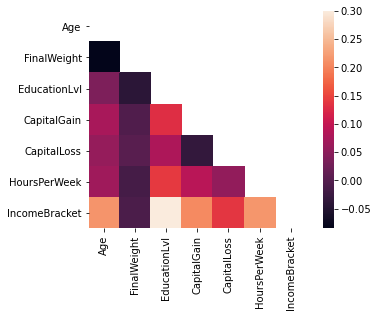

In [46]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, vmax=.3, square=True)
plt.show()

From the above corrolation obtained among numerical features after maping the income bracket, we see that the highest corrolation is between the EducationLvl and the income bracket, followed by Age, HoursPerWeek, CapitalGain, and finally Capital Loss. Final Weight seems to have the least corollation to Income Bracket. Furthermore, only numerical features are displayed here, in order to be able to obtain the corrolation of categorical data to target value, we must first convert the variables to numerical using one-hot-coding, so there would be no ordinal assumption made by the algorithms while corrolation and later models are calculated/used. 

#### New Feature
A new feature that is going to be added to the dataset called the Net capital gain, which equals to the individual's capital gain minus that individuals capita loss. This feature allows the information provided in two columns if the data set to be combined in one column. The minus value means the capital loss is higher than capital gain, while the positive value means that the gain of the individual was higher. This allows us to drop the two columns and only keep one column for processing, thus, improving all algorithms' data computation. 

In general feature engineering is useful for taking out the redundant information, thus improving model by making features more indep of one another and by making the computation faster. 

In [47]:
def NetGain(Capital):
    CapitalGain, CapitalLoss = Capital
    Net = CapitalGain - CapitalLoss
    return Net

trainDF['NetCapital'] = trainDF[['CapitalGain', 'CapitalLoss']].apply(NetGain, axis=1)
testDF['NetCapital'] = testDF[['CapitalGain', 'CapitalLoss']].apply(NetGain, axis=1)
trainDF = trainDF.drop(['CapitalGain', 'CapitalLoss'], axis=1)
testDF = testDF.drop(['CapitalGain', 'CapitalLoss'], axis=1)

#### Converting categorical data to numerical after some feature selection 

In [48]:
def makeDfDummy(DF):
    tempDF = pd.get_dummies(DF) 
    # Drop one of each of the dummy variables because its value is implied
    X = tempDF.drop(['WorkClass_Never-worked','Occupation_Unemployed',
                     'Relationship_Other-relative','Race_Other', 'Sex_Male', 
                     'NativeCountry_Other','MaritalStatus_Married-spouse-absent'],axis=1)
    return X

X_train = makeDfDummy(trainDF)
X_test = makeDfDummy(testDF)

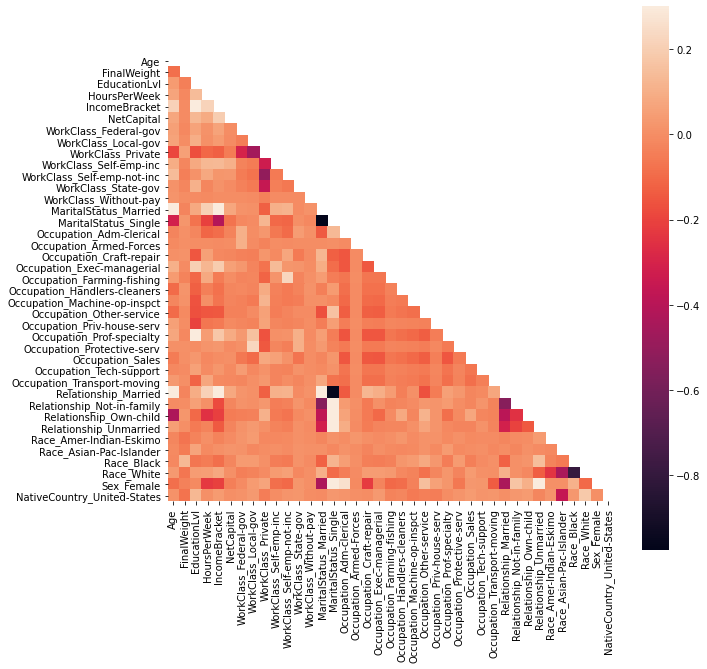

In [49]:
ax, figure = plt.subplots(figsize=(10,10))
corr = X_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, vmax=.3, square=True)
plt.show()

In the above corrolation map we see that a lot of features do not have high corrolations to the income bracket, thus, we can eliminate a lot of features. In order to determine which features have the highest impact on the model, I used the important feature detector of the gradient boosting to determine the top features to keep. 

In [50]:
# Seperate X and Y
X_train = X_train.drop(['IncomeBracket'], axis=1)
y_train = trainDF.IncomeBracket

X_test = X_test.drop(['IncomeBracket'], axis=1)
y_test = testDF.IncomeBracket

In [51]:
# store the name of the features in order 
feature_names = X_train.columns

#### Feature Elimination

In [52]:
# scale features 
X_train_scale = scaler.fit_transform(X_train)

In [53]:
# Initilize the model then fit with training data.
g_boost = XGBClassifier()
kfold_model_run(g_boost, X_train_scale, y_train, K=3)

Fold 1: Accuracy: 0.811
Fold 2: Accuracy: 0.815
Fold 3: Accuracy: 0.811
Average Score: 81.257%(0.204%)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

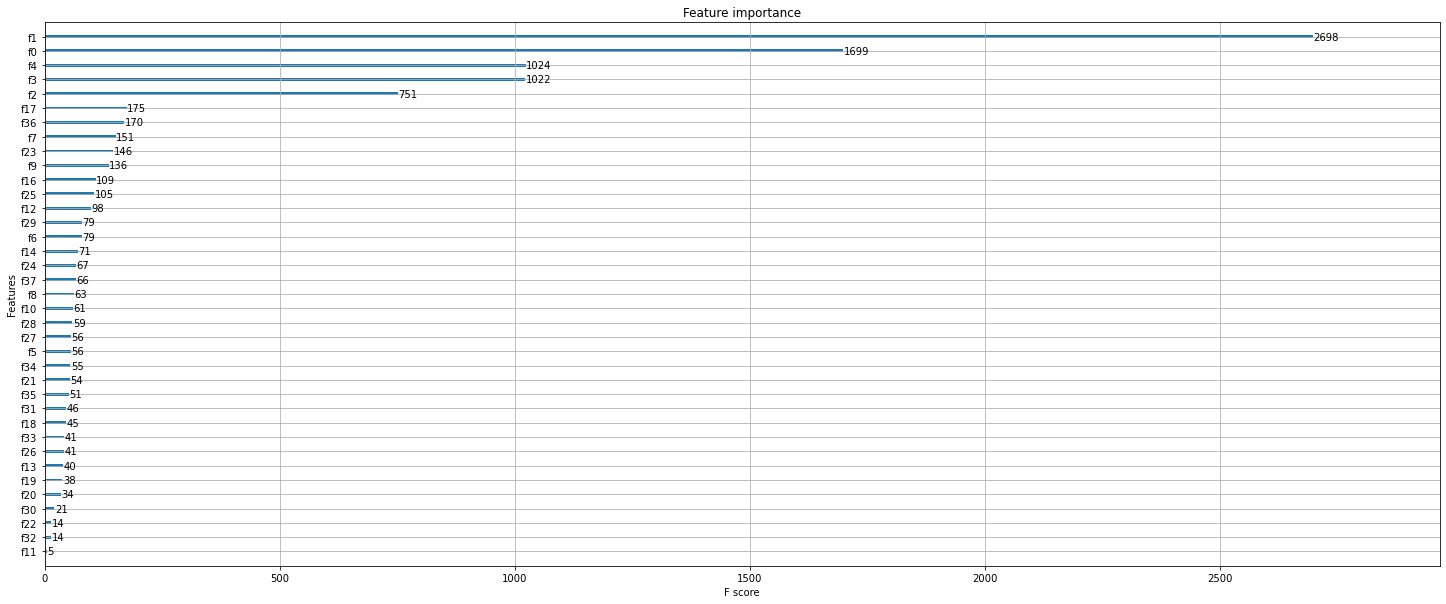

In [54]:
ax = plot_importance(g_boost)
fig = ax.figure
fig.set_size_inches(25, 10)
plt.show()

In [55]:
feature = g_boost.feature_importances_
Dic = dict(zip(feature_names,feature))
print('Top features in order are:')

print(feature_names[4])
print(feature_names[0])
print(feature_names[2])
print(feature_names[3])
print(feature_names[1])
print(feature_names[12])
print(feature_names[18])
print(feature_names[21])
print(feature_names[17])
print(feature_names[9])
print(feature_names[34])
print(feature_names[24])
print(feature_names[28])
print(feature_names[20])
print(feature_names[16])

Top features in order are:
NetCapital
Age
EducationLvl
HoursPerWeek
FinalWeight
MaritalStatus_Married
Occupation_Farming-fishing
Occupation_Other-service
Occupation_Exec-managerial
WorkClass_Self-emp-not-inc
Race_Black
Occupation_Protective-serv
Relationship_Married
Occupation_Machine-op-inspct
Occupation_Craft-repair


In the trend section, we saw clear relation between Capital gain and the target variable as well as age and education level with target variable. 
Let's see how the model performs with top 10, and then 15 features only. The effects of eliminating features could be that model becomes less accurate, as in general adding more features tends to make models more accurate, however, it increase the computation time and the chance of overfitting.

In [56]:
print('Slecting top 10 features')
X_train_less = X_train[['NetCapital','Age','EducationLvl','HoursPerWeek','FinalWeight',
                      'Relationship_Married','Occupation_Other-service',
                      'Occupation_Farming-fishing','Occupation_Exec-managerial',
                      'WorkClass_Self-emp-not-inc']]
# scale features 
X_train_scale = scaler.fit_transform(X_train_less)

start_time = time.time()
kfold_model_run(lg, X_train_scale, y_train)
elapsedtime = time.time() - start_time
print('Time taken to run this model is {} sec'.format(elapsedtime))

print('Slecting top 15 features')
X_train_less = X_train[['NetCapital','Age','EducationLvl','HoursPerWeek','FinalWeight',
                      'Relationship_Married','Occupation_Other-service',
                      'Occupation_Farming-fishing','Occupation_Exec-managerial',
                      'WorkClass_Self-emp-not-inc','WorkClass_Local-gov',
                       'Occupation_Machine-op-inspct','Occupation_Handlers-cleaners',
                      'Race_Black','Occupation_Protective-serv']]
# scale features 
X_train_scale = scaler.fit_transform(X_train_less)

start_time = time.time()
kfold_model_run(lg, X_train_scale, y_train)
elapsedtime = time.time() - start_time
print('Time taken to run this model is {} sec'.format(elapsedtime))


Slecting top 10 features
Fold 1: Accuracy: 0.792
Fold 2: Accuracy: 0.798
Fold 3: Accuracy: 0.797
Fold 4: Accuracy: 0.814
Fold 5: Accuracy: 0.799
Fold 6: Accuracy: 0.801
Fold 7: Accuracy: 0.789
Fold 8: Accuracy: 0.793
Fold 9: Accuracy: 0.801
Fold 10: Accuracy: 0.789
Average Score: 79.727%(0.692%)
Time taken to run this model is 3.859100341796875 sec
Slecting top 15 features
Fold 1: Accuracy: 0.796
Fold 2: Accuracy: 0.796
Fold 3: Accuracy: 0.796
Fold 4: Accuracy: 0.815
Fold 5: Accuracy: 0.798
Fold 6: Accuracy: 0.8
Fold 7: Accuracy: 0.792
Fold 8: Accuracy: 0.793
Fold 9: Accuracy: 0.801
Fold 10: Accuracy: 0.788
Average Score: 79.743%(0.674%)
Time taken to run this model is 3.9219820499420166 sec


In [57]:
X_train_less = X_train
i = 0
elim = []
for i in range(len(feature)):
    if feature[i] == 0.0:
        elim.append(X_train_less.columns[i])
        print('Column {} has small Fscore value, thus not important and is eliminated'.format(X_train_less.columns[i]))
X_train_less = X_train_less.drop(elim, axis=1)

X_train_scale = scaler.fit_transform(X_train_less)
start_time = time.time()
kfold_model_run(lg, X_train_scale, y_train)
elapsedtime = time.time() - start_time
print('Time taken to run this model is {} sec'.format(elapsedtime))


Column Occupation_Armed-Forces has small Fscore value, thus not important and is eliminated


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 1: Accuracy: 0.792


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 2: Accuracy: 0.796


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 3: Accuracy: 0.798


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 4: Accuracy: 0.812


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 5: Accuracy: 0.8


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 6: Accuracy: 0.803


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 7: Accuracy: 0.796


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 8: Accuracy: 0.792


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 9: Accuracy: 0.805
Fold 10: Accuracy: 0.79
Average Score: 79.842%(0.658%)
Time taken to run this model is 17.224191665649414 sec


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In the above only the features with 0 Fscore were removed. The model accuracy has drop slightly, and variance has increased tiny bit, but the model runs more than two times faster.

In [58]:
X_train_less = X_train

i = 0
elim = []
for i in range(len(feature)):
    if feature[i] <= 0.007:
        elim.append(X_train_less.columns[i])
        print()
        print('Column {} has small Fscore value, thus not important and is eliminated'.format(X_train_less.columns[i]))
X_train_less = X_train_less.drop(elim, axis=1)

X_train_scale = scaler.fit_transform(X_train_less)
start_time = time.time()
kfold_model_run(lg, X_train_scale, y_train)
elapsedtime = time.time() - start_time
print('Time taken to run this model is {} sec'.format(elapsedtime))
print('Total number of features kept are: {}'.format(X_train_less.columns.size))


Column WorkClass_Local-gov has small Fscore value, thus not important and is eliminated

Column WorkClass_Private has small Fscore value, thus not important and is eliminated

Column WorkClass_State-gov has small Fscore value, thus not important and is eliminated

Column WorkClass_Without-pay has small Fscore value, thus not important and is eliminated

Column Occupation_Armed-Forces has small Fscore value, thus not important and is eliminated

Column Occupation_Craft-repair has small Fscore value, thus not important and is eliminated

Column Occupation_Priv-house-serv has small Fscore value, thus not important and is eliminated

Column Occupation_Protective-serv has small Fscore value, thus not important and is eliminated

Column Relationship_Unmarried has small Fscore value, thus not important and is eliminated

Column Race_Amer-Indian-Eskimo has small Fscore value, thus not important and is eliminated

Column Race_Asian-Pac-Islander has small Fscore value, thus not important and is

In the above results we see that the model accuracy is very close to the baseline, where all features were included, however only total of 22 features are used instead of 83, and the run time of the algorithm has improve by about 9 times. Accuracy has dropped by less than 0.5% while the variance has incereased by about 1%. Thus, I picked the top 22 important features resulted from gradient boosting algorithm to continue with model implementation. 

In [59]:
# drop the same features in the test data
X_train = X_train_less
X_test = X_test.drop(elim, axis=1)

# Model Implementation 

Implemented 5 different classification algorithms, namely: Logistic Regression, Decision Tree, Random Forest, KNN, and Gradient boosting to run on the training dataset using 10-fold cross-validation. 


In [60]:
# scale the features
X_train = scaler.fit_transform(X_train)

In [61]:

### logitic regression model ###
#Algorithm: it is supervised classification algorithm, that estimates the probability that y=1 
# given input x. for multi-class problems picks a class that max h_of_theta(x)
#Pros: provides convenient probability score of observation, efficient implementation
#Cons: logistic regression does not consider the interactions among the features, doesnt 
# perform well when feature space is too large
#Why Chosen: The most common algorithm for solving classification problems 
logistic_reg_model = LogisticRegression()

### Decision Tree model ###
#Algorithm: supervised, both classification and regression, it partitions samples into mutually
# exclusive groups by selecting spliting attributes. It branches out based on the decrease in
# entropy and the most information gained, thus, the most important features appear at the top
#Pros: works with multiple modeling objectives, easy to interpret, handles missing data, works
# well for both large and small datasets, no need to normalize data, handles nonlinearity of
# features 
#Cons: easy to overfit, highly biased to train set, doesn't model interactions between features
#Why Chosen: designed to work well with multi-class and descrete intervals and the model is 
# easy and intuitive to understand
dtree_model = tree.DecisionTreeClassifier(criterion = "entropy",min_samples_leaf = 500)

### Random Forest model ###
#Algorithm: supervised, used for both classification and regression, it is a forest of 
# decision trees that are randomely divided, normally is low bias, high variance 
#Cons: although better than decision trees, it can still be greedy and overfit data
#Pros: doesn't overfit, captures nonlinearities between features and target 
#Why Chosen: since it addresses the shortcoming of the decision tree as it is a clever extension
# decision tree as features are randomly divided, it is less susceptible to muilticolinearity
Random_Forest_model = RandomForestClassifier()

### KNN model ###
#Algorithm: supervised, used for both classification and regression, for classification 
#problems, depending on the predetermined value of K, the alogirhtm finds the distance 
# between the new object and the training data. It then selects the K nearest neighbours and 
# classifies the new object based on the majority neighbour votes 
#Pros: easy to understand, 
#Cons: K value has to be pre-set, low K results in overfit, while high K results in underfit
# error also tends to be large when dataset is small
#Why Chosen: easy to understand and tune, it takes voting of neighbours so works well with 
# picking one out of 3 class 
knn_model = KNeighborsClassifier(n_neighbors=20)

### Gradient boosting model ###
#Algorithm: works based on the principal of ensemble since it combines a set of weak learners 
# to improve prediction accuracy. 
#Pros: higher accuracy as it minimizes an error, modest memory 
#Cons: computationally expensive, difficult to interprate, 
#not good for higher dimensional sparse features
#Why Chosen: boositing algorithms in general play a crucial role in bias/variance tradeoff 
# as they control both bias and variance, the next step is optimized by a correction measure 
# calculated in the previous step
g_boost = XGBClassifier()

# fit models with training data.
print('Running 10-fold validation on Logistic Regression')
kfold_model_run(logistic_reg_model, X_train, y_train)
print('Running 10-fold validation on Decision Tree')
dt = kfold_model_run(dtree_model, X_train, y_train)
print('Running 10-fold validation on Random Forest')
kfold_model_run(Random_Forest_model, X_train, y_train)
print('Running 10-fold validation on KNN, K = 20')
kfold_model_run(knn_model, X_train, y_train)
print('Running 10-fold validation on Gradient Boosting')
kfold_model_run(g_boost, X_train, y_train)

Running 10-fold validation on Logistic Regression
Fold 1: Accuracy: 0.792
Fold 2: Accuracy: 0.798
Fold 3: Accuracy: 0.798
Fold 4: Accuracy: 0.812
Fold 5: Accuracy: 0.802
Fold 6: Accuracy: 0.801
Fold 7: Accuracy: 0.793
Fold 8: Accuracy: 0.792
Fold 9: Accuracy: 0.805
Fold 10: Accuracy: 0.79
Average Score: 79.834%(0.644%)
Running 10-fold validation on Decision Tree
Fold 1: Accuracy: 0.784
Fold 2: Accuracy: 0.789
Fold 3: Accuracy: 0.782
Fold 4: Accuracy: 0.798
Fold 5: Accuracy: 0.793
Fold 6: Accuracy: 0.793
Fold 7: Accuracy: 0.784
Fold 8: Accuracy: 0.781
Fold 9: Accuracy: 0.791
Fold 10: Accuracy: 0.783
Average Score: 78.78%(0.546%)
Running 10-fold validation on Random Forest
Fold 1: Accuracy: 0.785
Fold 2: Accuracy: 0.8
Fold 3: Accuracy: 0.794
Fold 4: Accuracy: 0.804
Fold 5: Accuracy: 0.8
Fold 6: Accuracy: 0.793
Fold 7: Accuracy: 0.793
Fold 8: Accuracy: 0.793
Fold 9: Accuracy: 0.798
Fold 10: Accuracy: 0.78
Average Score: 79.41%(0.679%)
Running 10-fold validation on KNN, K = 20
Fold 1: Accu

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

From above we see that all models perform well across the folds, and their variance is small. Overal, based on the accuracy results we see that gradient boosting performs the best.

# Hyperparameter Tuning 

GridSearchCV, a well-known method for tuning the hyperparameters, is used which would result in optimized models. Grid search works by building several models with all the parameter combinations specified, and runs a defult of 3 cross validations to return a set of parameters that had the highest accuracy score on the validation set based on the chosen accuracy scorer. A search consists of:
-an estimator (regressor or classifier such as RandomForestClassifier(), or LogisticRegression())
-a parameter space
-a method for searching or sampling candidates
-a cross-validation scheme
-a score function, such as accurracy_score()
The drawback is that this step takes a very long time to run. 

The optimal hyperparameter set is then used to run 10-fold cross validation in order to obtain the average score of optimal parameters as well as confusion matrix and run-time of all the implemented algorithms. The model with highest score is slected, which is Gradient boosting.

In [62]:
### Logistic Regression model hyper-parameter tuning
lg = LogisticRegression(random_state=42)
# Create hyperparameter search space 
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
# Create hyperparameter options
lg_params = dict(C=C, penalty=penalty)

### Decision Tree model hyper-parameter tuning
dt = tree.DecisionTreeClassifier()
# Choose some parameter combinations to tune
dt_params = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10, 100,500, 1000],
              "max_leaf_nodes": [None, 5, 10, 20,25],
              }

### Random Forest model hyper-parameter tuning
rf = RandomForestClassifier()
# Choose some parameter combinations to tune
rf_params = {'n_estimators': [4, 9, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 5, 10,15], 
              'min_samples_split': [2, 3, 5,10],
              'min_samples_leaf': [1,5,8]
             }

### KNN model hyper-parameter tuning
knn = KNeighborsClassifier()
# Choose some parameter combinations to tune
knn_params = {"n_neighbors": np.arange(5, 35, 4), 
              "metric": ["euclidean", 'minkowski']}

### Gradient boost model hyper-parameter tuning
gboost = XGBClassifier()
# Choose some parameter combinations to tune
gboost_params = {'gamma': [0.05, 0.1, 0.3, 0.5,1], 
              'max_depth': [3, 5, 9], 
              'subsample': [0.6, 0.8, 0.9, 1]
                }

def run_gridsearch(clf, X, y, hyperparameters, cv=5):
    
    # Use classification accuracy to compare parameter combinations
    acc_scorer = make_scorer(accuracy_score)


    # Create grid search using k-fold cross validation
    grid_search = GridSearchCV(clf, hyperparameters, cv=cv, scoring=acc_scorer)
    grid_search = grid_search.fit(X, y)
    
    print('Best Score is:')
    best_score = grid_search.best_score_ 
    print((best_score*100))
    print('Best Model Hyperparameters are:')
    print(grid_search.best_params_)
    print('Best Model fit is:')
    print(grid_search.best_estimator_)
    
    # Set our classifier to have the best combination of parameters
    best_clf = grid_search.best_estimator_
     
    return best_clf

In [63]:
print('Logistic Regression Tuning')
best_lg = run_gridsearch(lg, X_train, y_train, lg_params)
print('Decision Tree Tuning')
best_dt = run_gridsearch(dt, X_train, y_train, dt_params)
print('Random Forest Tuning')
best_rf = run_gridsearch(rf, X_train, y_train, rf_params)
print('KNN Tuning')
best_knn = run_gridsearch(knn, X_train, y_train, knn_params)
print('Gradient Boosting Tuning')
best_gboost = run_gridsearch(gboost, X_train, y_train, gboost_params)

Logistic Regression Tuning


C:\Users\falak\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\falak\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\falak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\falak\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this trai

Best Score is:
79.90370488891598
Best Model Hyperparameters are:
{'C': 1.0, 'penalty': 'l2'}
Best Model fit is:
LogisticRegression(random_state=42)
Decision Tree Tuning
Best Score is:
80.64434911951427
Best Model Hyperparameters are:
{'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Model fit is:
DecisionTreeClassifier(max_leaf_nodes=20)
Random Forest Tuning
Best Score is:
81.1052011347561
Best Model Hyperparameters are:
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 9}
Best Model fit is:
RandomForestClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       min_samples_leaf=8, min_samples_split=3, n_estimators=9)
KNN Tuning
Best Score is:
79.21243829488589
Best Model Hyperparameters are:
{'metric': 'euclidean', 'n_neighbors': 29}
Best Model fit is:
KNeighborsClassifier(metric='euclidean', n_neighbors=29)
Gradi

In [64]:
# let's evaluate and see which model performs the best after hyperparameter tuning 
def model_eval(best_clf, X, y, K=5):
    # Fit the best model with optimal hyper parameters to the training data. 
    kfold = KFold(n_splits=K)
    kfold.get_n_splits(X)
    accuracy = np.zeros(K)
    np_idx = 0
    best_acc = 0
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        best_clf.fit(X_train, y_train)

        predictions = best_clf.predict(X_test)

        ACC = accuracy_score(y_test, predictions)
        accuracy[np_idx] = ACC*100
        np_idx += 1

          
        if ACC > best_acc:
            best_acc = ACC
            perform_measure = confusion_matrix(y_test, predictions)
    print("Model {}".format(best_clf))
    print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),
                                            round(np.std(accuracy),3)))
    print ('The 3-Class Confussion Matrix is:')
    print(perform_measure)
    return True 

In [65]:
print('Logistic Regression')
start_time = time.time()
model_eval(best_lg, X_train, y_train)
elapsedtime = time.time() - start_time
print('Time taken to run this model is {} sec'.format(elapsedtime))

print('Decision Tree')
start_time = time.time()
model_eval(best_dt, X_train, y_train)
elapsedtime = time.time() - start_time
print('Time taken to run this model is {} sec'.format(elapsedtime))

print('Random Forest')
start_time = time.time()
model_eval(best_rf, X_train, y_train)
elapsedtime = time.time() - start_time
print('Time taken to run this model is {} sec'.format(elapsedtime))

print('KNN')
start_time = time.time()
model_eval(best_knn, X_train, y_train)
elapsedtime = time.time() - start_time
print('Time taken to run this model is {} sec'.format(elapsedtime))

print('Gradient Boosting')
start_time = time.time()
model_eval(g_boost, X_train, y_train)
elapsedtime = time.time() - start_time
print('Time taken to run this model is {} sec'.format(elapsedtime))


Logistic Regression
Model LogisticRegression(random_state=42)
Average Score: 79.904%(0.465%)
The 3-Class Confussion Matrix is:
[[3497  175    0]
 [ 387  419    0]
 [ 201  182    0]]
Time taken to run this model is 5.065755605697632 sec
Decision Tree
Model DecisionTreeClassifier(max_leaf_nodes=20)
Average Score: 80.657%(0.435%)
The 3-Class Confussion Matrix is:
[[3558  135    0]
 [ 405  391    0]
 [ 161  211    0]]
Time taken to run this model is 0.6727843284606934 sec
Random Forest
Model RandomForestClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       min_samples_leaf=8, min_samples_split=3, n_estimators=9)
Average Score: 80.846%(0.478%)
The 3-Class Confussion Matrix is:
[[3566  105    1]
 [ 403  396    7]
 [ 207  173    3]]
Time taken to run this model is 1.8036713600158691 sec
KNN
Model KNeighborsClassifier(metric='euclidean', n_neighbors=29)
Average Score: 79.184%(0.44%)
The 3-Class Confussion Matrix is:
[[3500  162   10]
 [ 425  364   17]
 [ 217

In terms of accuracy, gradient boosting gives the highest accuracy of 81.3% with the lowest variance of all. It is the second slowest model and takes about 4.5 seconds to run, KNN is the slowest model of all taking about 13 seconds to complete, while decision tree is the fastest model taking less that quarter of second to run. 

The confusion matrix provides great deal of information on how the model is performing. Below is the guide on how to interprate the matrix:   Algorithm's Prediction
                                       Actual [ <50K | 50-100K | >100K]
                                       Actual [ <50K | 50-100K | >100K]
                                       Actual [ <50K | 50-100K | >100K]
In general all models are bad at categorizing >100K, which is understandable as the training data available on this class is much less than <50K class. On the other hand, all performed well in detecting the <50K class.
Overal, gradient boosting performed better than other models and moving forward Gradient boosting is chosen to perform the testing as it results in the highest accuracy, reasonable run time, better detection of <50K and 50-100K classes. 

# Testing

The purpose of this section is to make predictions on which income bracket people in the data fall into using the optimal model implemented and answer the question: how the model performs on the test data vs. the train data?

To test if the model is overfitting, we compared the training and testing accuracy. we find testing accuracy is comparable to the training accuracy and that model generalizes well. 

In [66]:
# get the optimal model
optimal_model =  best_gboost


# scale all the features 
X_test = scaler.fit_transform(X_test)

# train the optimal model on the entire training dataset 
optimal_model.fit(X_train, y_train)

# Predict the testing dataset income bracket class 
predictions = optimal_model.predict(X_test)
ACC = accuracy_score(y_test, predictions)
perform_measure = confusion_matrix(y_test, predictions)

print("Acuracy Score of the Optimal Model is: {}%".format(round(ACC*100),1))
print ('The 3-Class Confussion Matrix is:')
print(perform_measure)

Acuracy Score of the Optimal Model is: 79.0%
The 3-Class Confussion Matrix is:
[[8691  380    6]
 [1011  938   33]
 [ 591  476   18]]


The score is very close to the 81% of the training data. We see that the model generalizes well as the accuracy doesn't drop a lot from the training to testing set. In addition, we see the model performing much better in the case of <50K as there are more samples to learn from, and progresively gets worse at predicting the upper income brackets. 